# Cloning FAIM and MIMIC-IV-ED Benchmark Repos

In [ ]:
!git clone https://github.com/nliulab/mimic4ed-benchmark.git

Cloning into 'mimic4ed-benchmark'...
remote: Enumerating objects: 793, done.
remote: Counting objects: 100% (261/261), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 793 (delta 193), reused 191 (delta 191), pack-reused 532 (from 1)
Receiving objects: 100% (793/793), 201.77 MiB | 21.94 MiB/s, done.
Resolving deltas: 100% (488/488), done.
Updating files: 100% (73/73), done.


# Create master dataset

In [ ]:
from datetime import timedelta
from google.cloud import bigquery
import pandas as pd
import numpy as np
import re
import os
import math
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from sklearn import metrics
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
import collections
from pandas.io import gbq
from sklearn.model_selection import train_test_split
import pickle
from sklearn.impute import SimpleImputer
import itertools




import sys
sys.path.append('/content/mimic4ed-benchmark/Benchmark_scripts')
from medcodes import charlson, elixhauser
from medcodes.diagnoses.icd_conversion import convert_9to10_list, convert_10to9_list
from medcodes.diagnoses._mappers.icd10to9_dict import icd10to9dict
from medcodes.diagnoses._mappers.icd9to10_dict import icd9to10dict
from medcodes.diagnoses._mappers.elixhauser_charlson import (
    charlson_codes_v9,
    charlson_codes_v10,
    elixhauser_codes_v9,
    elixhauser_codes_v10,
    comorbidity_mappers
)


In [ ]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

output_path = '/content/drive/MyDrive/mimic4_output'
os.makedirs(output_path, exist_ok=True)

Mounted at /content/drive


In [ ]:
# Create client
client = bigquery.Client(project='perfect-crow-472910-d7')

In [ ]:
# All the tables for easy accessibility
table_map = {
    # ICU tables
    "chartevents": "physionet-data.mimiciv_3_1_icu.chartevents",
    "datetimeevents": "physionet-data.mimiciv_3_1_icu.datetimeevents",
    "d_items": "physionet-data.mimiciv_3_1_icu.d_items",
    "icustays": "physionet-data.mimiciv_3_1_icu.icustays",
    "inputevents": "physionet-data.mimiciv_3_1_icu.inputevents",
    "outputevents": "physionet-data.mimiciv_3_1_icu.outputevents",
    "procedureevents": "physionet-data.mimiciv_3_1_icu.procedureevents",

    # Core tables
    "patients": "physionet-data.mimiciv_3_1_hosp.patients",
    "admissions": "physionet-data.mimiciv_3_1_hosp.admissions",
    "transfers": "physionet-data.mimiciv_3_1_hosp.transfers",

    # Hospital tables
    "d_hcpcs": "physionet-data.mimiciv_3_1_hosp.d_hcpcs",
    "d_icd_diagnoses": "physionet-data.mimiciv_3_1_hosp.d_icd_diagnoses",
    "d_labitems": "physionet-data.mimiciv_3_1_hosp.d_labitems",
    "emar": "physionet-data.mimiciv_3_1_hosp.emar",
    "hcpcsevents": "physionet-data.mimiciv_3_1_hosp.hcpcsevents",
    "microbiologyevents": "physionet-data.mimiciv_3_1_hosp.microbiologyevents",
    "poe": "physionet-data.mimiciv_3_1_hosp.poe",
    "prescriptions": "physionet-data.mimiciv_3_1_hosp.prescriptions",
    "services": "physionet-data.mimiciv_3_1_hosp.services",
    "diagnoses_icd": "physionet-data.mimiciv_3_1_hosp.diagnoses_icd",
    "d_icd_procedures": "physionet-data.mimiciv_3_1_hosp.d_icd_procedures",
    "drgcodes": "physionet-data.mimiciv_3_1_hosp.drgcodes",
    "emar_detail": "physionet-data.mimiciv_3_1_hosp.emar_detail",
    "labevents": "physionet-data.mimiciv_3_1_hosp.labevents",
    "pharmacy": "physionet-data.mimiciv_3_1_hosp.pharmacy",
    "poe_detail": "physionet-data.mimiciv_3_1_hosp.poe_detail",
    "procedures_icd": "physionet-data.mimiciv_3_1_hosp.procedures_icd",

    # ED tables
    "diagnosis": "physionet-data.mimiciv_ed.diagnosis",
    "edstays": "physionet-data.mimiciv_ed.edstays",
    "medrecon": "physionet-data.mimiciv_ed.medrecon",
    "pyxis": "physionet-data.mimiciv_ed.pyxis",
    "triage": "physionet-data.mimiciv_ed.triage",
    "vitalsign": "physionet-data.mimiciv_ed.vitalsign"
}


In [ ]:
def load_table(table_name):
    print(f"Loading: {table_name}")
    query = f"SELECT * FROM `{table_map[table_name]}`"
    return client.query(query).to_dataframe()

In [ ]:
# Required tables
df_edstays = load_table("edstays")
df_patients = load_table("patients")
df_admissions = load_table("admissions")
df_icustays = load_table("icustays")
df_triage = load_table("triage")
df_vitalsign = load_table("vitalsign")
df_pyxis = load_table("pyxis")
df_medrecon = load_table("medrecon")
df_diagnoses = load_table("diagnoses_icd")

Loading: edstays
Loading: patients
Loading: admissions
Loading: icustays
Loading: triage
Loading: vitalsign
Loading: pyxis
Loading: medrecon
Loading: diagnoses_icd


In [ ]:
def convert_str_to_float(x):
    if isinstance(x, str):
        x_split = re.compile('[^a-zA-Z0-9-]').split(x.strip())
        if '-' in x_split[0]:
            x_split_dash = x_split[0].split('-')
            if len(x_split_dash) == 2 and x_split_dash[0].isnumeric() and x_split_dash[1].isnumeric():
                return (float(x_split_dash[0]) + float(x_split_dash[1])) / 2
            else:
                return np.nan
        else:
            if x_split[0].isnumeric():
                return float(x_split[0])
            else:
                return np.nan
    else:
        return x

In [ ]:
df_edstays['intime'] = pd.to_datetime(df_edstays['intime'])
df_edstays['outtime'] = pd.to_datetime(df_edstays['outtime'])

df_patients['dod'] = pd.to_datetime(df_patients['dod'])

df_admissions = df_admissions.rename(columns={"race": "ethnicity"})
df_admissions =  df_admissions[['subject_id', 'hadm_id', 'admittime', 'dischtime', 'deathtime','ethnicity', 'edregtime','edouttime']]
df_admissions['admittime'] = pd.to_datetime(df_admissions['admittime'])
df_admissions['dischtime'] = pd.to_datetime(df_admissions['dischtime'])
df_admissions['deathtime'] = pd.to_datetime(df_admissions['deathtime'])

df_icustays['intime'] = pd.to_datetime(df_icustays['intime'])
df_icustays['outtime'] = pd.to_datetime(df_icustays['outtime'])

vital_rename_dict = {vital: '_'.join(['triage', vital]) for vital in ['temperature', 'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp', 'pain', 'acuity']}
df_triage.rename(vital_rename_dict, axis=1, inplace=True)
df_triage['triage_pain'] = df_triage['triage_pain'].apply(convert_str_to_float).astype(float)

vital_rename_dict = {vital: '_'.join(['ed', vital]) for vital in
                      ['temperature', 'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp', 'rhythm', 'pain']}
df_vitalsign.rename(vital_rename_dict, axis=1, inplace=True)

df_vitalsign['ed_pain'] = df_vitalsign['ed_pain'].apply(convert_str_to_float).astype(float)


# ED root table, demographic and outcomes


In [ ]:
def merge_edstays_patients_on_subject(df_edstays,df_patients):
    if 'gender' in df_edstays.columns:
        df_edstays = pd.merge(df_edstays, df_patients[['subject_id', 'anchor_age', 'anchor_year','dod']], on = ['subject_id'], how='left')
    else:
        df_edstays = pd.merge(df_edstays, df_patients[['subject_id', 'anchor_age', 'gender', 'anchor_year','dod']], on = ['subject_id'], how='left')
    return df_edstays

def merge_edstays_admissions_on_subject(df_edstays ,df_admissions):
    df_edstays = pd.merge(df_edstays,df_admissions, on = ['subject_id', 'hadm_id'], how='left')
    return df_edstays

def merge_edstays_triage_on_subject(df_master ,df_triage):
    df_master = pd.merge(df_master,df_triage, on = ['subject_id', 'stay_id'], how='left')
    return df_master

def add_age(df_master):
    df_master['in_year'] = df_master['intime'].dt.year
    df_master['age'] = df_master['in_year'] - df_master['anchor_year'] + df_master['anchor_age']
    #df_master.drop(['anchor_age', 'anchor_year', 'in_year'],axis=1, inplace=True)
    return df_master

def add_inhospital_mortality(df_master):
    inhospital_mortality = df_master['dod'].notnull() & (df_master['dischtime'] >= df_master['dod'])
    df_master['outcome_inhospital_mortality'] = inhospital_mortality
    return df_master

def add_ed_los(df_master):
    ed_los = df_master['outtime'] - df_master['intime']
    df_master['ed_los'] = ed_los
    return df_master


def add_outcome_icu_transfer(df_master, df_icustays, timerange):
    timerange_delta = timedelta(hours = timerange)
    df_icustays_sorted = df_icustays[['subject_id', 'hadm_id', 'intime']].sort_values('intime')
    df_icustays_keep_first = df_icustays_sorted.groupby('hadm_id').first().reset_index()
    df_master_icu = pd.merge(df_master, df_icustays_keep_first, on = ['subject_id', 'hadm_id'], how='left', suffixes=('','_icu'))
    time_diff = (df_master_icu['intime_icu']- df_master_icu['outtime'])
    df_master_icu['time_to_icu_transfer'] = time_diff
    df_master_icu[''.join(['outcome_icu_transfer_', str(timerange), 'h'])] = time_diff <= timerange_delta
    # df_master_icu.drop(['intime_icu', 'time_to_icu_transfer'],axis=1, inplace=True)
    return df_master_icu

def fill_na_ethnicity(df_master): # requires df_master to be sorted
    N = len(df_master)
    ethnicity_list= [float("NaN") for _ in range(N)]
    ethnicity_dict = {} # dict to store subejct ethnicity

    def get_filled_ethnicity(row):
        i = row.name
        if i % 10000 == 0:
            print('Process: %d/%d' % (i, N), end='\r')
        curr_eth = row['ethnicity']
        curr_subject = row['subject_id']
        prev_subject = df_master['subject_id'][i+1] if i< (N-1) else None

        if curr_subject not in ethnicity_dict.keys(): ## if subject ethnicity not stored yet, look ahead and behind
            subject_ethnicity_list = []
            next_subject_idx = i+1
            prev_subject_idx = i-1
            next_subject= df_master['subject_id'][next_subject_idx] if next_subject_idx <= (N-1) else None
            prev_subject= df_master['subject_id'][prev_subject_idx] if prev_subject_idx >= 0 else None

            subject_ethnicity_list.append(df_master['ethnicity'][i]) ## add current ethnicity to list

            while prev_subject == curr_subject:
                subject_ethnicity_list.append(df_master['ethnicity'][prev_subject_idx])
                prev_subject_idx -= 1
                prev_subject= df_master['subject_id'][prev_subject_idx] if prev_subject_idx >= 0 else None

            while next_subject == curr_subject:
                subject_ethnicity_list.append(df_master['ethnicity'][next_subject_idx])
                next_subject_idx += 1
                next_subject= df_master['subject_id'][next_subject_idx] if next_subject_idx <= (N-1) else None

            eth_counter_list = collections.Counter(subject_ethnicity_list).most_common() #sorts counter and outputs list

            if len(eth_counter_list) == 0: ## no previous or next entries
                subject_eth = curr_eth
            elif len(eth_counter_list) == 1: ## exactly one other ethnicity
                subject_eth = eth_counter_list.pop(0)[0] ## extract ethnicity from count tuple
            else:
                eth_counter_list = [x for x in eth_counter_list if pd.notna(x[0])] # remove any NA
                subject_eth = eth_counter_list.pop(0)[0]

            ethnicity_dict[curr_subject] = subject_eth ## store in dict

        if pd.isna(curr_eth): ## if curr_eth is na, fill with subject_eth from dict
            ethnicity_list[i]= ethnicity_dict[curr_subject]
        else:
            ethnicity_list[i]= curr_eth

    df_master.apply(get_filled_ethnicity, axis=1)
    print('Process: %d/%d' % (N, N), end='\r')
    df_master.loc[:,'ethnicity'] = ethnicity_list
    return df_master

In [ ]:
icu_transfer_timerange = 12  # hours
next_ed_visit_timerange = 3  # days

In [ ]:
# Merge edstays with patients
df_master = merge_edstays_patients_on_subject(df_edstays, df_patients)

print('Merged edstays with patients.')

# Merge with admissions (adds age, mortality, ICU transfer outcome)
df_master = merge_edstays_admissions_on_subject(df_master, df_admissions)

print('Merged with admissions.')


# Add more features
df_master = add_age(df_master)
df_master = add_inhospital_mortality(df_master)
df_master = add_ed_los(df_master)
df_master = add_outcome_icu_transfer(df_master, df_icustays, icu_transfer_timerange)

print('Added more features')

# Add outcome columns
df_master['outcome_hospitalization'] = ~pd.isnull(df_master['hadm_id'])
df_master['outcome_critical'] = (
    df_master['outcome_inhospital_mortality'] |
    df_master[f'outcome_icu_transfer_{icu_transfer_timerange}h']
)

print('Added outcome columns')

# Sort master table
df_master = df_master.sort_values(['subject_id', 'intime']).reset_index(drop=True)

print('Sorted master table.')

# Fill missing ethnicity values
df_master = fill_na_ethnicity(df_master)

print('Filled missing ethnicity values.')


Merged edstays with patients.
Merged with admissions.
Added more features
Added outcome columns
Sorted master table.
Filled missing ethnicity values.


In [ ]:
df_master

,subject_id,hadm_id,stay_id,intime,outtime,gender,race,arrival_transport,disposition,anchor_age,...,edouttime,in_year,age,outcome_inhospital_mortality,ed_los,intime_icu,time_to_icu_transfer,outcome_icu_transfer_12h,outcome_hospitalization,outcome_critical
0,10000032,22595853,33258284,2180-05-06 19:17:00,2180-05-06 23:30:00,F,WHITE,AMBULANCE,ADMITTED,52,...,2180-05-06 23:30:00,2180,52,False,0 days 04:13:00,NaT,NaT,False,True,False
1,10000032,22841357,38112554,2180-06-26 15:54:00,2180-06-26 21:31:00,F,WHITE,AMBULANCE,ADMITTED,52,...,2180-06-26 21:31:00,2180,52,False,0 days 05:37:00,NaT,NaT,False,True,False
2,10000032,29079034,32952584,2180-07-22 16:24:00,2180-07-23 05:54:00,F,WHITE,AMBULANCE,HOME,52,...,2180-07-23 14:00:00,2180,52,False,0 days 13:30:00,2180-07-23 14:00:00,0 days 08:06:00,True,True,True
3,10000032,29079034,39399961,2180-07-23 05:54:00,2180-07-23 14:00:00,F,WHITE,AMBULANCE,ADMITTED,52,...,2180-07-23 14:00:00,2180,52,False,0 days 08:06:00,2180-07-23 14:00:00,0 days 00:00:00,True,True,True
4,10000032,25742920,35968195,2180-08-05 20:58:00,2180-08-06 01:44:00,F,WHITE,AMBULANCE,ADMITTED,52,...,2180-08-06 01:44:00,2180,52,False,0 days 04:46:00,NaT,NaT,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
425082,19999784,25715748,34149746,2119-08-11 09:15:00,2119-08-11 13:40:00,M,BLACK/AFRICAN AMERICAN,WALK IN,ADMITTED,57,...,2119-08-11 13:40:00,2119,57,False,0 days 04:25:00,NaT,NaT,False,True,False
425083,19999828,29734428,30712109,2147-07-17 17:18:00,2147-07-18 17:34:00,F,WHITE,WALK IN,ADMITTED,46,...,2147-07-18 17:34:00,2147,46,False,1 days 00:16:00,NaT,NaT,False,True,False
425084,19999828,25744818,32917002,2149-01-08 09:11:00,2149-01-08 18:12:00,F,WHITE,AMBULANCE,ADMITTED,46,...,2149-01-08 18:12:00,2149,48,False,0 days 09:01:00,2149-01-08 18:12:00,0 days 00:00:00,True,True,True
425085,19999914,<NA>,32002659,2158-12-24 11:41:00,2158-12-24 11:56:00,F,UNKNOWN,UNKNOWN,ELOPED,49,...,NaT,2158,49,False,0 days 00:15:00,NaT,NaT,False,False,False


In [ ]:
df_master['sex'] = df_master['gender']
df_master.drop(['gender'], axis=1, inplace=True)

# Health Utilization

In [ ]:
def generate_past_ed_visits(df_master, timerange):
    #df_master = df_master.sort_values(['subject_id', 'intime']).reset_index()

    timerange_delta = timedelta(days=timerange)
    N = len(df_master)
    n_ed = [0 for _ in range(N)]

    def get_num_past_ed_visits(df):
        start = df.index[0]
        for i in df.index:
            if i % 10000 == 0:
                print('Process: %d/%d' % (i, N), end='\r')
            while df.loc[i, 'intime'] - df.loc[start, 'intime'] > timerange_delta:
                start += 1
            n_ed[i] = i - start

    grouped = df_master.groupby('subject_id')
    #grouped.apply(get_num_past_ed_visits, include_group=False)
    grouped.apply(get_num_past_ed_visits)

    print('Process: %d/%d' % (N, N), end='\r')

    df_master.loc[:, ''.join(['n_ed_', str(timerange), "d"])] = n_ed

    return df_master

def generate_past_admissions(df_master, df_admissions, timerange):
    df_admissions_sorted = df_admissions[df_admissions['subject_id'].isin(df_master['subject_id'].unique().tolist())][['subject_id', 'admittime']].copy()

    df_admissions_sorted.loc[:,'admittime'] = pd.to_datetime(df_admissions_sorted['admittime'])
    df_admissions_sorted.sort_values(['subject_id', 'admittime'], inplace=True)
    df_admissions_sorted.reset_index(drop=True, inplace=True)

    timerange_delta = timedelta(days=timerange)

    N = len(df_master)
    n_adm = [0 for _ in range(N)]

    def get_num_past_admissions(df):
        subject_id = df.iloc[0]['subject_id']
        if subject_id in grouped_adm.groups.keys():
            df_adm = grouped_adm.get_group(subject_id)
            start = end = df_adm.index[0]
            for i in df.index:
                if i % 10000 == 0:
                    print('Process: %d/%d' % (i, N), end='\r')
                while start < df_adm.index[-1] and df.loc[i, 'intime'] - df_adm.loc[start, 'admittime'] > timerange_delta:
                    start += 1
                end = start
                while end <= df_adm.index[-1] and \
                        (timerange_delta >= (df.loc[i, 'intime'] - df_adm.loc[end, 'admittime']) > timedelta(days=0)):
                    end += 1
                n_adm[i] = end - start

    grouped = df_master.groupby('subject_id')
    grouped_adm = df_admissions_sorted.groupby('subject_id')
    #grouped.apply(get_num_past_admissions, include_group=False)
    grouped.apply(get_num_past_admissions)

    print('Process: %d/%d' % (N, N), end='\r')

    df_master.loc[:,''.join(['n_hosp_', str(timerange), "d"])] = n_adm

    return df_master


def generate_past_icu_visits(df_master, df_icustays, timerange):
    df_icustays_sorted = df_icustays[df_icustays['subject_id'].isin(df_master['subject_id'].unique().tolist())][['subject_id', 'intime']].copy()
    df_icustays_sorted.sort_values(['subject_id', 'intime'], inplace=True)
    df_icustays_sorted.reset_index(drop=True, inplace=True)

    timerange_delta = timedelta(days=timerange)
    N = len(df_master)
    n_icu = [0 for _ in range(N)]
    def get_num_past_icu_visits(df):
        subject_id = df.iloc[0]['subject_id']
        if subject_id in grouped_icu.groups.keys():
            df_icu = grouped_icu.get_group(subject_id)
            start = end = df_icu.index[0]
            for i in df.index:
                if i % 10000 == 0:
                    print('Process: %d/%d' % (i, N), end='\r')
                while start < df_icu.index[-1] and df.loc[i, 'intime'] - df_icu.loc[start, 'intime'] > timerange_delta:
                    start += 1
                end = start
                while end <= df_icu.index[-1] and \
                        (timerange_delta >= (df.loc[i, 'intime'] - df_icu.loc[end, 'intime']) > timedelta(days=0)):
                    end += 1
                n_icu[i] = end - start

    grouped = df_master.groupby('subject_id')
    grouped_icu = df_icustays_sorted.groupby('subject_id')
    #grouped.apply(get_num_past_icu_visits, include_group=False)
    grouped.apply(get_num_past_icu_visits)

    print('Process: %d/%d' % (N, N), end='\r')

    df_master.loc[:,''.join(['n_icu_', str(timerange), "d"])] = n_icu

    return df_master


def generate_future_ed_visits(df_master, next_ed_visit_timerange):
    N = len(df_master)
    time_of_next_ed_visit = [float("NaN") for _ in range(N)]
    time_to_next_ed_visit = [float("NaN") for _ in range(N)]
    outcome_ed_revisit = [False for _ in range(N)]

    timerange_delta = timedelta(days = next_ed_visit_timerange)

    curr_subject=None
    next_subject=None

    def get_future_ed_visits(row):
        i = row.name
        if i % 10000 == 0:
            print('Process: %d/%d' % (i, N), end='\r')
        curr_subject = row['subject_id']
        next_subject= df_master['subject_id'][i+1] if i< (N-1) else None

        if curr_subject == next_subject:
            curr_outtime = row['outtime']
            next_intime = df_master['intime'][i+1]
            next_intime_diff = next_intime - curr_outtime

            time_of_next_ed_visit[i] = next_intime
            time_to_next_ed_visit[i] = next_intime_diff
            outcome_ed_revisit[i] = next_intime_diff < timerange_delta

    df_master.apply(get_future_ed_visits, axis=1)
    print('Process: %d/%d' % (N, N), end='\r')

    df_master.loc[:,'next_ed_visit_time'] = time_of_next_ed_visit
    df_master.loc[:,'next_ed_visit_time_diff'] = time_to_next_ed_visit
    df_master.loc[:,''.join(['outcome_ed_revisit_', str(next_ed_visit_timerange), "d"])] = outcome_ed_revisit

    return df_master


def generate_numeric_timedelta(df_master):
    N = len(df_master)
    ed_los_hours = [float("NaN") for _ in range(N)]
    time_to_icu_transfer_hours = [float("NaN") for _ in range(N)]
    next_ed_visit_time_diff_days = [float("NaN") for _ in range(N)]

    def get_numeric_timedelta(row):
        i = row.name
        if i % 10000 == 0:
            print('Process: %d/%d' % (i, N), end='\r')
        curr_subject = row['subject_id']
        curr_ed_los = row['ed_los']
        curr_time_to_icu_transfer = row['time_to_icu_transfer']
        curr_next_ed_visit_time_diff = row['next_ed_visit_time_diff']


        ed_los_hours[i] = round(curr_ed_los.total_seconds() / (60*60),2) if not pd.isna(curr_ed_los) else curr_ed_los
        time_to_icu_transfer_hours[i] = round(curr_time_to_icu_transfer.total_seconds() / (60*60),2) if not pd.isna(curr_time_to_icu_transfer) else curr_time_to_icu_transfer
        next_ed_visit_time_diff_days[i] = round(curr_next_ed_visit_time_diff.total_seconds() / (24*60*60), 2) if not pd.isna(curr_next_ed_visit_time_diff) else curr_next_ed_visit_time_diff


    df_master.apply(get_numeric_timedelta, axis=1)
    print('Process: %d/%d' % (N, N), end='\r')

    df_master.loc[:,'ed_los_hours'] = ed_los_hours
    df_master.loc[:,'time_to_icu_transfer_hours'] = time_to_icu_transfer_hours
    df_master.loc[:,'next_ed_visit_time_diff_days'] = next_ed_visit_time_diff_days

    return df_master

In [ ]:
# This code block takes about 20 minutes to run.

## Generate past ED visits
## aka total ED visits in the past _ days
df_master = generate_past_ed_visits(df_master, timerange=30)
df_master = generate_past_ed_visits(df_master, timerange=90)
df_master = generate_past_ed_visits(df_master, timerange=365)

print('Generated past ED visits')

## Oucome: future ED revisit variables
## aka see if patient visited ED again within 3 days of being discharged
df_master = generate_future_ed_visits(df_master, next_ed_visit_timerange)

print('Generated future ED visits')

## Generate past admissions
df_master = generate_past_admissions(df_master, df_admissions, timerange=30)
df_master = generate_past_admissions(df_master, df_admissions, timerange=90)
df_master = generate_past_admissions(df_master, df_admissions, timerange=365)

print('Generated past admissions')

## Generate past icu visits
df_master  = generate_past_icu_visits(df_master, df_icustays, timerange=30)
df_master  = generate_past_icu_visits(df_master, df_icustays, timerange=90)
df_master  = generate_past_icu_visits(df_master, df_icustays, timerange=365)

print('Generated past icu visits')

## Generate numeric timedelta variables
## convert timedelat objects into numbers
df_master = generate_numeric_timedelta(df_master)

print('Generated numeric timedelta variables')

/tmp/ipython-input-2243338282.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped.apply(get_num_past_ed_visits)


/tmp/ipython-input-2243338282.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped.apply(get_num_past_ed_visits)


/tmp/ipython-input-2243338282.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped.apply(get_num_past_ed_visits)


Generated past ED visits
Generated future ED visits


/tmp/ipython-input-2243338282.py:58: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped.apply(get_num_past_admissions)


/tmp/ipython-input-2243338282.py:58: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped.apply(get_num_past_admissions)


/tmp/ipython-input-2243338282.py:58: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped.apply(get_num_past_admissions)


Generated past admissions


/tmp/ipython-input-2243338282.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped.apply(get_num_past_icu_visits)


/tmp/ipython-input-2243338282.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped.apply(get_num_past_icu_visits)


/tmp/ipython-input-2243338282.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped.apply(get_num_past_icu_visits)


Generated past icu visits
Generated numeric timedelta variables


# Triage Information

In [ ]:
complaint_dict = {"chiefcom_chest_pain" : "chest pain", "chiefcom_abdominal_pain" : "abdominal pain|abd pain",
"chiefcom_headache" : "headache|lightheaded", "chiefcom_shortness_of_breath" : "breath", "chiefcom_back_pain" : "back pain", "chiefcom_cough" : "cough",
"chiefcom_nausea_vomiting" : "nausea|vomit", "chiefcom_fever_chills" : "fever|chill", "chiefcom_syncope" :"syncope", "chiefcom_dizziness" : "dizz"}

def encode_chief_complaints(df_master, complaint_dict):

    holder_list = []
    complaint_colnames_list = list(complaint_dict.keys())
    complaint_regex_list = list(complaint_dict.values())

    for i, row in df_master.iterrows():
        curr_patient_complaint = str(row['chiefcomplaint'])
        curr_patient_complaint_list = [False for _ in range(len(complaint_regex_list))]
        complaint_idx = 0

        for complaint in complaint_regex_list:
            if re.search(complaint, curr_patient_complaint, re.IGNORECASE):
                curr_patient_complaint_list[complaint_idx] = True
            complaint_idx += 1

        holder_list.append(curr_patient_complaint_list)

    df_encoded_complaint = pd.DataFrame(holder_list, columns = complaint_colnames_list)

    df_master = pd.concat([df_master,df_encoded_complaint], axis=1)
    return df_master

In [ ]:
## Merging with triage table, Comment: revise the variable names? triage_*
df_master = merge_edstays_triage_on_subject(df_master, df_triage) ## note change to merge master

print('Merged with triage table')

## Encoding 10 chief complaints
df_master = encode_chief_complaints(df_master, complaint_dict)

print('Encoded 10 chief complaints')

Merged with triage table
Encoded 10 chief complaints


# Comorbidities from diagnosis ICD

In [ ]:
cci_var_map = {
    'myocardial infarction': 'cci_MI',
    'congestive heart failure': 'cci_CHF',
    'peripheral vascular disease': 'cci_PVD',
    'cerebrovascular disease': 'cci_Stroke',
    'dementia': 'cci_Dementia',
    'chronic pulmonary disease': 'cci_Pulmonary',
    'rheumatic disease': 'cci_Rheumatic',
    'peptic ulcer disease': 'cci_PUD',
    'mild liver disease': 'cci_Liver1',
    'diabetes without chronic complication': 'cci_DM1',
    'diabetes with chronic complication': 'cci_DM2',
    'hemiplegia or paraplegia': 'cci_Paralysis',
    'renal disease': 'cci_Renal',
    'malignancy': 'cci_Cancer1',
    'moderate or severe liver disease': 'cci_Liver2',
    'metastatic solid tumor': 'cci_Cancer2',
    'AIDS/HIV': 'cci_HIV'
}

eci_var_map = {
'congestive heart failure' : 'eci_CHF',
'cardiac arrhythmias' : 'eci_Arrhythmia',
'valvular disease' : 'eci_Valvular',
'pulmonary circulation disorders' : 'eci_PHTN',
'peripheral vascular disorders' : 'eci_PVD',
'hypertension, complicated' : 'eci_HTN1',
'hypertension, uncomplicated' : 'eci_HTN2',
'paralysis' : 'eci_Paralysis',
'other neurological disorders' : 'eci_NeuroOther',
'chronic pulmonary disease' : 'eci_Pulmonary',
'diabetes, complicated' : 'eci_DM1',
'diabetes, uncomplicated' : 'eci_DM2',
'hypothyroidism' : 'eci_Hypothyroid',
'renal failure' : 'eci_Renal',
'liver disease' : 'eci_Liver',
'peptic ulcer disease excluding bleeding' : 'eci_PUD',
'AIDS/HIV' : 'eci_HIV',
'lymphoma' : 'eci_Lymphoma',
'metastatic cancer' : 'eci_Tumor2',
'solid tumor without metastasis' : 'eci_Tumor1',
'rheumatoid arthritis' : 'eci_Rheumatic',
'coagulopathy' : 'eci_Coagulopathy',
'obesity' : 'eci_Obesity',
'weight loss' : 'eci_WeightLoss',
'fluid and electrolyte disorders' : 'eci_FluidsLytes',
'blood loss anemia' : 'eci_BloodLoss',
'deficiency anemia' : 'eci_Anemia',
'alcohol abuse' : 'eci_Alcohol',
'drug abuse' : 'eci_Drugs',
'psychoses' : 'eci_Psychoses',
'depression' : 'eci_Depression'
}

map_dict = {'charlson': cci_var_map,
            'elixhauser': eci_var_map}

empty_map_vector = {k:{v:0 for key, v in map_i.items()} for k, map_i in map_dict.items()}


def commorbidity_set(icd, version, mapping='charlson'):
    c_list = []
    if mapping == 'charlson':
        for i, c in enumerate(icd):
            c_list.extend(charlson(c, version[i]))
    elif mapping == 'elixhauser':
        for i, c in enumerate(icd):
            c_list.extend(elixhauser(c, version[i]))
    else:
        raise ValueError(
            f"{mapping} is not a recognized mapping. It must be \'charlson\' or \'elixhauser\'")
    return set(c_list)


def commorbidity_dict(icd, version, mapping='charlson'):
    map_set = commorbidity_set(icd, version, mapping)
    map_vector = empty_map_vector[mapping].copy()
    for c in map_set:
        map_vector[map_dict[mapping][c]] = 1
    return map_vector


def diagnosis_with_time(df_diagnoses, df_admissions):
    df_diagnoses_with_adm = pd.merge(df_diagnoses, df_admissions.loc[:, [
                                     'hadm_id', 'subject_id', 'dischtime']], on=['subject_id', 'hadm_id'], how='left')
    df_diagnoses_with_adm.loc[:, 'dischtime'] = pd.to_datetime(
        df_diagnoses_with_adm.loc[:, 'dischtime'])
    df_diagnoses_sorted = df_diagnoses_with_adm.sort_values(
        ['subject_id', 'dischtime']).reset_index()
    return df_diagnoses_sorted

def encode_icd_to_index(codes, icd_encode_mapping):
    encoded_list = []
    for code in codes:
        encoded_list.append(icd_encode_mapping[code])
    return encoded_list

def icd_list(df_edstays, df_diagnoses, df_admissions, timerange, version=9, digit3=False):
    timerange = timedelta(days=timerange)
    icd_set = set({})
    df_diagnoses_sorted = diagnosis_with_time(df_diagnoses, df_admissions)
    #print(f"Total diagnoses before filtering: {df_diagnoses_sorted['icd_code'].nunique()}")
    j_start = 0
    j_end = 0
    prev_subject = None
    diagnoses = []
    stay_ids = []
    # Loop through ED visits
    for i, row in df_edstays.iterrows():
        if i % 10000 == 0:
            print('Process: %d/%d' % (i, len(df_edstays)), end='\r')
        # If new subject, find the start and end index of same subject in sorted admission df
        stay_ids.append(row['stay_id'])
        if row['subject_id'] != prev_subject:
            j_start = j_end
            while j_start < len(df_diagnoses_sorted) and df_diagnoses_sorted['subject_id'][j_start] < row['subject_id']:
                j_start += 1
            j_end = j_start

            while j_end < len(df_diagnoses_sorted) and df_diagnoses_sorted['subject_id'][j_end] == row['subject_id']:
                j_end += 1
            prev_subject = row['subject_id']
        # Count number of previous admissions within the time range
        icd_list = []
        version_list = []
        for j in range(j_start, j_end):
            if row['intime'] > df_diagnoses_sorted['dischtime'][j] and row['intime']-df_diagnoses_sorted['dischtime'][j] <= timerange:
                icd_list.append(df_diagnoses_sorted.loc[j, 'icd_code'])
                version_list.append(df_diagnoses_sorted.loc[j, 'icd_version'])
        if version==10:
            icd_list = set(convert_9to10_list(icd_list, version_list))
        else:
            icd_list = set(convert_10to9_list(icd_list, version_list, digit3=digit3))
        diagnoses.append(icd_list)
        icd_set.update(icd_list)
    #print(f"Unique ICDs after linking and timerange: {len(icd_set)}")

    icd_encode_mapping = {code:i for i, code in enumerate(icd_set)}

    diagnoses_record = []
    for i, codes in enumerate(diagnoses):
        index_codes = encode_icd_to_index(codes, icd_encode_mapping)
        diagnoses_record.append({'stay_id':stay_ids[i], 'icd_list': codes, 'icd_encoded_list':index_codes})
    df_icd_list = pd.DataFrame.from_records(diagnoses_record)
    return df_icd_list, icd_encode_mapping

def extract_icd_list(df_edstays, df_diagnoses, df_admissions, output_path, timerange = 356*5, version = 'v9_3digit'):
    if version == 'v9_3digit':
        df_icd_list, icd_encode_map = icd_list(df_edstays, df_diagnoses, df_admissions, timerange = timerange, version = 9, digit3=True)
    elif version == 'v9':
        df_icd_list, icd_encode_map = icd_list(df_edstays, df_diagnoses, df_admissions, timerange = timerange, version = 9, digit3=False)
    elif version == 'v10':
        df_icd_list, icd_encode_map = icd_list(df_edstays, df_diagnoses, df_admissions, timerange = timerange, version = 10, digit3=False)
    df_icd_list.to_csv(os.path.join(output_path, 'icd_list_dataset_'+version+'.csv'), index=False)
    with open(os.path.join(output_path, 'icd_encode_map_'+version),'wb') as f:
        pickle.dump(icd_encode_map,f)
    print('Number of unique ICD codes '+version+': ', len(icd_encode_map))


def commorbidity(df_master, df_diagnoses, df_admissions, timerange):
    timerange = timedelta(days=timerange)

    df_diagnoses_sorted = diagnosis_with_time(df_diagnoses, df_admissions)
    #df_master = df_master.sort_values(['subject_id', 'stay_id'])

    j_start = 0
    j_end = 0
    prev_subject = None
    diagnoses = []
    versions = []
    stay_ids = []
    # Loop through ED visits
    for i, row in df_master.iterrows():
        stay_ids.append(row['stay_id'])
        if i % 10000 == 0:
            print('Process: %d/%d' % (i, len(df_master)), end='\r')
        # If new subject, find the start and end index of same subject in sorted admission df
        if row['subject_id'] != prev_subject:
            j_start = j_end
            while j_start < len(df_diagnoses_sorted) and df_diagnoses_sorted['subject_id'][j_start] < row['subject_id']:
                j_start += 1
            j_end = j_start

            while j_end < len(df_diagnoses_sorted) and df_diagnoses_sorted['subject_id'][j_end] == row['subject_id']:
                j_end += 1
            prev_subject = row['subject_id']
        # Count number of previous admissions within the time range
        icd_list = []
        version_list = []
        for j in range(j_start, j_end):
            if row['intime'] > df_diagnoses_sorted['dischtime'][j] and row['intime']-df_diagnoses_sorted['dischtime'][j] <= timerange:
                icd_list.append(df_diagnoses_sorted.loc[j, 'icd_code'])
                version_list.append(df_diagnoses_sorted.loc[j, 'icd_version'])
        diagnoses.append(icd_list)
        versions.append(version_list)

    cci_eci=[]
    for i, code in enumerate(diagnoses):
        cci_eci.append({'stay_id':stay_ids[i], **commorbidity_dict(code, versions[i], mapping='charlson'), **commorbidity_dict(code, versions[i], mapping='elixhauser')})
    df_cci_eci = pd.DataFrame.from_records(cci_eci)
    df_master = pd.merge(df_master, df_cci_eci, on='stay_id', how='left')
    return df_master

In [ ]:
# This function takes about 30 min
df_master = commorbidity(df_master, df_diagnoses, df_admissions, timerange = 356*5)
print('Commorbidity function complete')

Commorbidity function complete


In [ ]:
extract_icd_list(df_edstays, df_diagnoses, df_admissions, output_path, timerange = 356*5, version = 'v9')
print('First ICD function complete')
extract_icd_list(df_edstays, df_diagnoses, df_admissions, output_path, timerange = 356*5, version = 'v9_3digit')
print('Second ICD function complete')
extract_icd_list(df_edstays, df_diagnoses, df_admissions, output_path, timerange = 356*5, version = 'v10')
print('Third ICD function complete')

Number of unique ICD codes v9:  1719
First ICD function complete
Number of unique ICD codes v9_3digit:  1648
Second ICD function complete
Number of unique ICD codes v10:  1862
Third ICD function complete


Different than author's original results, but I believe it is due to a newer version of MIMICIV-ED that has less rows

# ED Vital signs

In [ ]:
def merge_vitalsign_info_on_edstay(df_master, df_vitalsign, options=[]):
    df_vitalsign.sort_values('charttime', inplace=True)

    grouped = df_vitalsign.groupby(['stay_id'])

    for option in options:
        method = getattr(grouped, option, None)
        assert method is not None, "Invalid option. " \
                                   "Should be a list of values from 'max', 'min', 'median', 'mean', 'first', 'last'. " \
                                   "e.g. ['median', 'last']"
        df_vitalsign_option = method(numeric_only=True)
        df_vitalsign_option.rename({name: '_'.join([name, option]) for name in
                                    ['ed_temperature', 'ed_heartrate', 'ed_resprate', 'ed_o2sat', 'ed_sbp', 'ed_dbp', 'ed_pain']},
                                   axis=1,
                                   inplace=True)
        df_master = pd.merge(df_master, df_vitalsign_option, on=['subject_id', 'stay_id'], how='left')

    return df_master

In [ ]:
df_master = merge_vitalsign_info_on_edstay(df_master, df_vitalsign, options=['last'])

# Medication

In [ ]:
def merge_med_count_on_edstay(df_master, df_pyxis):
    df_pyxis_fillna = df_pyxis.copy()
    df_pyxis_fillna['gsn'].fillna(df_pyxis['name'], inplace=True)
    grouped = df_pyxis_fillna.groupby(['stay_id'])
    df_medcount = grouped['gsn'].nunique().reset_index().rename({'gsn': 'n_med'}, axis=1)
    df_master = pd.merge(df_master, df_medcount, on='stay_id', how='left')
    df_master.fillna({'n_med': 0}, inplace=True)
    return df_master

def merge_medrecon_count_on_edstay(df_master, df_medrecon):
    df_medrecon_fillna = df_medrecon.copy()
    df_medrecon_fillna['gsn'].fillna(df_medrecon['name'])
    grouped = df_medrecon_fillna.groupby(['stay_id'])
    df_medcount = grouped['gsn'].nunique().reset_index().rename({'gsn': 'n_medrecon'}, axis=1)
    df_master = pd.merge(df_master, df_medcount, on='stay_id', how='left')
    df_master.fillna({'n_medrecon': 0}, inplace=True)
    return df_master


In [ ]:
df_master = merge_med_count_on_edstay(df_master, df_pyxis)

/tmp/ipython-input-3711022398.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_pyxis_fillna['gsn'].fillna(df_pyxis['name'], inplace=True)


In [ ]:
df_master = merge_medrecon_count_on_edstay(df_master, df_medrecon)

# General filter - Age, triage_acuity

In [ ]:
print('Before filtering for "age" >= 18 : master dataset size = ', len(df_master))
df_master = df_master[df_master['age'] >= 18]
print('After filtering for "age" >= 18 : master dataset size = ', len(df_master))

Before filtering for "age" >= 18 : master dataset size =  425087
After filtering for "age" >= 18 : master dataset size =  425011


In [ ]:
print('Before filtering for non-null "triage_acuity" >= 18 : master dataset size = ', len(df_master))
df_master = df_master[df_master['triage_acuity'].notnull()]
print('After filtering for non-null "triage_acuity" >= 18 : master dataset size = ', len(df_master))

Before filtering for non-null "triage_acuity" >= 18 : master dataset size =  425011
After filtering for non-null "triage_acuity" >= 18 : master dataset size =  418025


# Outlier Detection

In [ ]:
# from mimic-extract
vitals_valid_range = {
    'temperature': {'outlier_low': 14.2, 'valid_low': 26, 'valid_high': 45, 'outlier_high':47},
    'heartrate': {'outlier_low': 0, 'valid_low': 0, 'valid_high': 350, 'outlier_high':390},
    'resprate': {'outlier_low': 0, 'valid_low': 0, 'valid_high': 300, 'outlier_high':330},
    'o2sat': {'outlier_low': 0, 'valid_low': 0, 'valid_high': 100, 'outlier_high':150},
    'sbp': {'outlier_low': 0, 'valid_low': 0, 'valid_high': 375, 'outlier_high':375},
    'dbp': {'outlier_low': 0, 'valid_low': 0, 'valid_high': 375, 'outlier_high':375},
    'pain': {'outlier_low': 0, 'valid_low': 0, 'valid_high': 10, 'outlier_high':10},
    'acuity': {'outlier_low': 1, 'valid_low': 1, 'valid_high': 5, 'outlier_high':5},
}

In [ ]:
def convert_temp_to_celcius(df_master):
    for column in df_master.columns:
        column_type = column.split('_')[1] if len(column.split('_')) > 1 else None
        if column_type == 'temperature':
            # Convert to float first to avoid Decimal type issues
            df_master[column] = df_master[column].astype(float)
            # Convert to celsius
            df_master[column] = (df_master[column] - 32) * 5/9
    return df_master

def outlier_removal_imputation(column_type, vitals_valid_range):
    column_range = vitals_valid_range[column_type]
    def outlier_removal_imputation_single_value(x):
      if x is None or (isinstance(x, float) and np.isnan(x)):
          return np.nan  # or keep as is
      if x < column_range['outlier_low'] or x > column_range['outlier_high']:
          return np.nan
      elif x < column_range['valid_low']:
          return column_range['valid_low']
      elif x > column_range['valid_high']:
          return column_range['valid_high']
      else:
          return x
    return outlier_removal_imputation_single_value

def remove_outliers(df_master, vitals_valid_range):
    for column in df_master.columns:
        column_type = column.split('_')[1] if len(column.split('_')) > 1 else None
        if column_type in vitals_valid_range:
            # Only apply to numeric columns to avoid errors
            if pd.api.types.is_numeric_dtype(df_master[column]):
                df_master[column] = df_master[column].apply(outlier_removal_imputation(column_type, vitals_valid_range))
    return df_master

def display_outliers_count(df_master, vitals_valid_range):
    display_rows = []

    for column in df_master.columns:
        column_type = column.split('_')[1] if len(column.split('_')) > 1 else None
        if column_type in vitals_valid_range:
            column_range = vitals_valid_range[column_type]

            row = {
                'variable': column,
                '< outlier_low': len(df_master[df_master[column] < column_range['outlier_low']]),
                '[outlier_low, valid_low)': len(df_master[(column_range['outlier_low'] <= df_master[column]) &
                                                          (df_master[column] < column_range['valid_low'])]),
                '[valid_low, valid_high]': len(df_master[(column_range['valid_low'] <= df_master[column]) &
                                                         (df_master[column] <= column_range['valid_high'])]),
                '(valid_high, outlier_high]': len(df_master[(column_range['valid_high'] < df_master[column]) &
                                                            (df_master[column] <= column_range['outlier_high'])]),
                '> outlier_high': len(df_master[df_master[column] > column_range['outlier_high']])
            }

            display_rows.append(row)

    # Convert list of dicts to DataFrame
    display_df = pd.DataFrame(display_rows)

    return display_df

In [ ]:
df_master = convert_temp_to_celcius(df_master)

In [ ]:
display_outliers_count(df_master, vitals_valid_range)

,variable,< outlier_low,"[outlier_low, valid_low)","[valid_low, valid_high]","(valid_high, outlier_high]",> outlier_high
0,triage_temperature,479,29,400914,0,9
1,triage_heartrate,0,0,407734,0,7
2,triage_resprate,0,0,404481,0,3
3,triage_o2sat,0,0,404190,6,41
4,triage_sbp,0,0,406528,0,16
5,triage_dbp,0,0,405350,0,395
6,triage_pain,0,0,386607,0,11191
7,triage_acuity,0,0,418025,0,0
8,ed_sbp_last,0,0,403017,0,1
9,ed_dbp_last,0,0,402762,0,256


# Downloading dataset

In [ ]:
df_master = remove_outliers(df_master, vitals_valid_range)

In [ ]:
df_master.to_csv('df_master.csv', index=False)
from google.colab import files
files.download('df_master.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# load df_master
df_master = pd.read_csv('df_master.csv')

# Dataset Split (train: 0.7, val: 0.1, test: 0.2, use seed to fix)

In [ ]:
# Create 70/10/20 split
dat_train, temp_df = train_test_split(df_master, test_size=0.3, random_state=42)
dat_expl, dat_test = train_test_split(temp_df, test_size=2/3, random_state=42)

In [ ]:
print('Training dataset size = ', len(dat_train))
print('Validation dataset size = ', len(dat_expl))
print('Testing dataset size = ', len(dat_test))

Training dataset size =  292617
Validation dataset size =  41802
Testing dataset size =  83606


# Missing Value imputation

In [ ]:
df_missing_stats = dat_train.isnull().sum().to_frame().T
df_missing_stats.loc[1] = df_missing_stats.loc[0] / len(dat_train)
df_missing_stats.index = ['no. of missing values', 'percentage of missing values']
df_missing_stats

,subject_id,hadm_id,stay_id,intime,outtime,race,arrival_transport,disposition,anchor_age,anchor_year,...,eci_Anemia,eci_Alcohol,eci_Drugs,eci_Psychoses,eci_Depression,ed_sbp_last,ed_dbp_last,ed_pain_last,n_med,n_medrecon
no. of missing values,0.0,154100.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,10590.000000,10772.000000,31492.000000,0.0,0.0
percentage of missing values,0.0,0.526627,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.036191,0.036813,0.107622,0.0,0.0


In [ ]:
# from mimic-extract
vitals_valid_range = {
    'temperature': {'outlier_low': 14.2, 'valid_low': 26, 'valid_high': 45, 'outlier_high':47},
    'heartrate': {'outlier_low': 0, 'valid_low': 0, 'valid_high': 350, 'outlier_high':390},
    'resprate': {'outlier_low': 0, 'valid_low': 0, 'valid_high': 300, 'outlier_high':330},
    'o2sat': {'outlier_low': 0, 'valid_low': 0, 'valid_high': 100, 'outlier_high':150},
    'sbp': {'outlier_low': 0, 'valid_low': 0, 'valid_high': 375, 'outlier_high':375},
    'dbp': {'outlier_low': 0, 'valid_low': 0, 'valid_high': 375, 'outlier_high':375},
    'pain': {'outlier_low': 0, 'valid_low': 0, 'valid_high': 10, 'outlier_high':10},
    'acuity': {'outlier_low': 1, 'valid_low': 1, 'valid_high': 5, 'outlier_high':5},
}

In [ ]:
vitals_cols = [col for col in df_master.columns if len(col.split('_')) > 1 and
                                                   col.split('_')[1] in vitals_valid_range and
                                                   col.split('_')[1] != 'acuity']
vitals_cols

['triage_temperature',
 'triage_heartrate',
 'triage_resprate',
 'triage_o2sat',
 'triage_sbp',
 'triage_dbp',
 'triage_pain',
 'ed_sbp_last',
 'ed_dbp_last',
 'ed_pain_last']

In [ ]:
vitals_cols = ['triage_temperature', 'triage_heartrate', 'triage_resprate',
               'triage_o2sat', 'triage_sbp', 'triage_dbp', 'triage_pain']
imputer = SimpleImputer(strategy='median')
dat_train[vitals_cols] = imputer.fit_transform(dat_train[vitals_cols])
dat_expl[vitals_cols] = imputer.transform(dat_expl[vitals_cols])
dat_test[vitals_cols] = imputer.transform(dat_test[vitals_cols])

# 5. Add Score values

### Score value functions

In [ ]:
def add_score_CCI(df):
    conditions = [
        (df['age'] < 50),
        (df['age'] >= 50) & (df['age'] <= 59),
        (df['age'] >= 60) & (df['age'] <= 69),
        (df['age'] >= 70) & (df['age'] <= 79),
        (df['age'] >= 80)
    ]
    values = [0, 1, 2, 3, 4]
    df['score_CCI'] = np.select(conditions, values)
    df['score_CCI'] = df['score_CCI'] + df['cci_MI'] + df['cci_CHF'] + df['cci_PVD'] + df['cci_Stroke'] + df['cci_Dementia'] + df['cci_Pulmonary'] + df['cci_PUD'] + df['cci_Rheumatic'] +df['cci_Liver1']*1 + df['cci_Liver2']*3 + df['cci_DM1'] + df['cci_DM2']*2 +df['cci_Paralysis']*2 + df['cci_Renal']*2 + df['cci_Cancer1']*2 + df['cci_Cancer2']*6 + df['cci_HIV']*6
    print("Variable 'add_score_CCI' successfully added")

def add_triage_MAP(df):
    df['triage_MAP'] = df['triage_sbp']*1/3 + df['triage_dbp']*2/3
    print("Variable 'add_triage_MAP' successfully added")

def add_score_REMS(df):
    conditions1 = [
        (df['age'] < 45),
        (df['age'] >= 45) & (df['age'] <= 54),
        (df['age'] >= 55) & (df['age'] <= 64),
        (df['age'] >= 65) & (df['age'] <= 74),
        (df['age'] > 74)
    ]
    values1 = [0, 2, 3, 5, 6]
    conditions2 = [
        (df['triage_MAP'] > 159),
        (df['triage_MAP'] >= 130) & (df['triage_MAP'] <= 159),
        (df['triage_MAP'] >= 110) & (df['triage_MAP'] <= 129),
        (df['triage_MAP'] >= 70) & (df['triage_MAP'] <= 109),
        (df['triage_MAP'] >= 50) & (df['triage_MAP'] <= 69),
        (df['triage_MAP'] < 49)
    ]
    values2 = [4, 3, 2, 0, 2, 4]
    conditions3 = [
        (df['triage_heartrate'] >179),
        (df['triage_heartrate'] >= 140) & (df['triage_heartrate'] <= 179),
        (df['triage_heartrate'] >= 110) & (df['triage_heartrate'] <= 139),
        (df['triage_heartrate'] >= 70) & (df['triage_heartrate'] <= 109),
        (df['triage_heartrate'] >= 55) & (df['triage_heartrate'] <= 69),
        (df['triage_heartrate'] >= 40) & (df['triage_heartrate'] <= 54),
        (df['triage_heartrate'] < 40)
    ]
    values3 = [4, 3, 2, 0, 2, 3, 4]
    conditions4 = [
        (df['triage_resprate'] > 49),
        (df['triage_resprate'] >= 35) & (df['triage_resprate'] <= 49),
        (df['triage_resprate'] >= 25) & (df['triage_resprate'] <= 34),
        (df['triage_resprate'] >= 12) & (df['triage_resprate'] <= 24),
        (df['triage_resprate'] >= 10) & (df['triage_resprate'] <= 11),
        (df['triage_resprate'] >= 6) & (df['triage_resprate'] <= 9),
        (df['triage_resprate'] < 6)
    ]
    values4 = [4, 3, 1, 0, 1, 2, 4]
    conditions5 = [
        (df['triage_o2sat'] < 75),
        (df['triage_o2sat'] >= 75) & (df['triage_o2sat'] <= 85),
        (df['triage_o2sat'] >= 86) & (df['triage_o2sat'] <= 89),
        (df['triage_o2sat'] > 89)
    ]
    values5 = [4, 3, 1, 0]
    df['score_REMS'] = np.select(conditions1, values1) + np.select(conditions2, values2) + np.select(conditions3, values3) +                              np.select(conditions4, values4) + np.select(conditions5, values5)
    print("Variable 'Score_REMS' successfully added")

def add_score_CART(df):
    conditions1 = [
        (df['age'] < 55),
        (df['age'] >= 55) & (df['age'] <= 69),
        (df['age'] >= 70)
    ]
    values1 = [0, 4, 9]
    conditions2 = [
        (df['triage_resprate'] < 21),
        (df['triage_resprate'] >= 21) & (df['triage_resprate'] <= 23),
        (df['triage_resprate'] >= 24) & (df['triage_resprate'] <= 25),
        (df['triage_resprate'] >= 26) & (df['triage_resprate'] <= 29),
        (df['triage_resprate'] >= 30)
    ]
    values2 = [0, 8, 12, 15, 22]
    conditions3 = [
        (df['triage_heartrate'] < 110),
        (df['triage_heartrate'] >= 110) & (df['triage_heartrate'] <= 139),
        (df['triage_heartrate'] >= 140)
    ]
    values3 = [0, 4, 13]
    conditions4 = [
        (df['triage_dbp'] > 49),
        (df['triage_dbp'] >= 40) & (df['triage_dbp'] <= 49),
        (df['triage_dbp'] >= 35) & (df['triage_dbp'] <= 39),
        (df['triage_dbp'] < 35)
    ]
    values4 = [0, 4, 6, 13]
    df['score_CART'] = np.select(conditions1, values1) + np.select(conditions2, values2) + np.select(conditions3, values3) +                              np.select(conditions4, values4)
    print("Variable 'Score_CART' successfully added")

def add_score_NEWS(df):
    conditions1 = [
        (df['triage_resprate'] <= 8),
        (df['triage_resprate'] >= 9) & (df['triage_resprate'] <= 11),
        (df['triage_resprate'] >= 12) & (df['triage_resprate'] <= 20),
        (df['triage_resprate'] >= 21) & (df['triage_resprate'] <= 24),
        (df['triage_resprate'] >= 25)
    ]
    values1 = [3, 1, 0, 2, 3]
    conditions2 = [
        (df['triage_o2sat'] <= 91),
        (df['triage_o2sat'] >= 92) & (df['triage_o2sat'] <= 93),
        (df['triage_o2sat'] >= 94) & (df['triage_o2sat'] <= 95),
        (df['triage_o2sat'] >= 96)
    ]
    values2 = [3, 2, 1, 0]
    conditions3 = [
        (df['triage_temperature'] <= 35),
        (df['triage_temperature'] > 35) & (df['triage_temperature'] <= 36),
        (df['triage_temperature'] > 36) & (df['triage_temperature'] <= 38),
        (df['triage_temperature'] > 38) & (df['triage_temperature'] <= 39),
        (df['triage_temperature'] > 39)
    ]
    values3 = [3, 1, 0, 1, 2]
    conditions4 = [
        (df['triage_sbp'] <= 90),
        (df['triage_sbp'] >= 91) & (df['triage_sbp'] <= 100),
        (df['triage_sbp'] >= 101) & (df['triage_sbp'] <= 110),
        (df['triage_sbp'] >= 111) & (df['triage_sbp'] <= 219),
        (df['triage_sbp'] > 219)
    ]
    values4 = [3, 2, 1, 0, 3]
    conditions5 = [
        (df['triage_heartrate'] <= 40),
        (df['triage_heartrate'] >= 41) & (df['triage_heartrate'] <= 50),
        (df['triage_heartrate'] >= 51) & (df['triage_heartrate'] <= 90),
        (df['triage_heartrate'] >= 91) & (df['triage_heartrate'] <= 110),
        (df['triage_heartrate'] >= 111) & (df['triage_heartrate'] <= 130),
        (df['triage_heartrate'] > 130)
    ]
    values5 = [3, 1, 0, 1, 2, 3]
    df['score_NEWS'] = np.select(conditions1, values1) + np.select(conditions2, values2) + np.select(conditions3, values3) +                              np.select(conditions4, values4) + np.select(conditions5, values5)
    print("Variable 'Score_NEWS' successfully added")

def add_score_NEWS2(df):
    conditions1 = [
        (df['triage_resprate'] <= 8),
        (df['triage_resprate'] >= 9) & (df['triage_resprate'] <= 11),
        (df['triage_resprate'] >= 12) & (df['triage_resprate'] <= 20),
        (df['triage_resprate'] >= 21) & (df['triage_resprate'] <= 24),
        (df['triage_resprate'] >= 25)
    ]
    values1 = [3, 1, 0, 2, 3]
    conditions2 = [
        (df['triage_temperature'] <= 35),
        (df['triage_temperature'] > 35) & (df['triage_temperature'] <= 36),
        (df['triage_temperature'] > 36) & (df['triage_temperature'] <= 38),
        (df['triage_temperature'] > 38) & (df['triage_temperature'] <= 39),
        (df['triage_temperature'] > 39)
    ]
    values2 = [3, 1, 0, 1, 2]
    conditions3 = [
        (df['triage_sbp'] <= 90),
        (df['triage_sbp'] >= 91) & (df['triage_sbp'] <= 100),
        (df['triage_sbp'] >= 101) & (df['triage_sbp'] <= 110),
        (df['triage_sbp'] >= 111) & (df['triage_sbp'] <= 219),
        (df['triage_sbp'] > 219)
    ]
    values3 = [3, 2, 1, 0, 3]
    conditions4 = [
        (df['triage_heartrate'] <= 40),
        (df['triage_heartrate'] >= 41) & (df['triage_heartrate'] <= 50),
        (df['triage_heartrate'] >= 51) & (df['triage_heartrate'] <= 90),
        (df['triage_heartrate'] >= 91) & (df['triage_heartrate'] <= 110),
        (df['triage_heartrate'] >= 111) & (df['triage_heartrate'] <= 130),
        (df['triage_heartrate'] > 130)
    ]
    values4 = [3, 1, 0, 1, 2, 3]
    df['score_NEWS2'] = np.select(conditions1, values1) + np.select(conditions2, values2) + np.select(conditions3, values3) +                              np.select(conditions4, values4)
    print("Variable 'Score_NEWS2' successfully added")

def add_score_MEWS(df):
    conditions1 = [
        (df['triage_sbp'] <= 70),
        (df['triage_sbp'] >= 71) & (df['triage_sbp'] <= 80),
        (df['triage_sbp'] >= 81) & (df['triage_sbp'] <= 100),
        (df['triage_sbp'] >= 101) & (df['triage_sbp'] <= 199),
        (df['triage_sbp'] > 199)
    ]
    values1 = [3, 2, 1, 0, 2]
    conditions2 = [
        (df['triage_heartrate'] <= 40),
        (df['triage_heartrate'] >= 41) & (df['triage_heartrate'] <= 50),
        (df['triage_heartrate'] >= 51) & (df['triage_heartrate'] <= 100),
        (df['triage_heartrate'] >= 101) & (df['triage_heartrate'] <= 110),
        (df['triage_heartrate'] >= 111) & (df['triage_heartrate'] <= 129),
        (df['triage_heartrate'] >= 130)
    ]
    values2 = [2, 1, 0, 1, 2, 3]
    conditions3 = [
        (df['triage_resprate'] < 9),
        (df['triage_resprate'] >= 9) & (df['triage_resprate'] <= 14),
        (df['triage_resprate'] >= 15) & (df['triage_resprate'] <= 20),
        (df['triage_resprate'] >= 21) & (df['triage_resprate'] <= 29),
        (df['triage_resprate'] >= 30)
    ]
    values3 = [2, 0, 1, 2, 3]
    conditions4 = [
        (df['triage_temperature'] < 35),
        (df['triage_temperature'] >= 35) & (df['triage_temperature'] < 38.5),
        (df['triage_temperature'] >= 38.5)
    ]
    values4 = [2, 0, 2]
    df['score_MEWS'] = np.select(conditions1, values1) + np.select(conditions2, values2) + np.select(conditions3, values3) +                              np.select(conditions4, values4)
    print("Variable 'Score_MEWS' successfully added")

def add_score_SERP2d(df):
    conditions1 = [
        (df['age'] < 30),
        (df['age'] >= 30) & (df['age'] <= 49),
        (df['age'] >= 50) & (df['age'] <= 79),
        (df['age'] >= 80)
    ]
    values1 = [0, 9, 13, 17]
    conditions2 = [
        (df['triage_heartrate'] < 60),
        (df['triage_heartrate'] >= 60) & (df['triage_heartrate'] <= 69),
        (df['triage_heartrate'] >= 70) & (df['triage_heartrate'] <= 94),
        (df['triage_heartrate'] >= 95) & (df['triage_heartrate'] <= 109),
        (df['triage_heartrate'] >= 110)
    ]
    values2 = [3, 0, 3, 6, 10]
    conditions3 = [
        (df['triage_resprate'] < 16),
        (df['triage_resprate'] >= 16) & (df['triage_resprate'] <= 19),
        (df['triage_resprate'] >= 20)
    ]
    values3 = [11, 0, 7]
    conditions4 = [
        (df['triage_sbp'] < 100),
        (df['triage_sbp'] >= 100) & (df['triage_sbp'] <= 114),
        (df['triage_sbp'] >= 115) & (df['triage_sbp'] <= 149),
        (df['triage_sbp'] >= 150)
    ]
    values4 = [10, 4, 1, 0]
    conditions5 = [
        (df['triage_dbp'] < 50),
        (df['triage_dbp'] >= 50) & (df['triage_dbp'] <= 94),
        (df['triage_dbp'] >= 95)
    ]
    values5 = [5, 0, 1]
    conditions6 = [
        (df['triage_o2sat'] < 90),
        (df['triage_o2sat'] >= 90) & (df['triage_o2sat'] <= 94),
        (df['triage_o2sat'] >= 95)
    ]
    values6 = [7, 5, 0]
    df['score_SERP2d'] = np.select(conditions1, values1) + np.select(conditions2, values2) + np.select(conditions3, values3) +                              np.select(conditions4, values4) + np.select(conditions5, values5) + np.select(conditions6, values6)
    print("Variable 'Score_SERP2d' successfully added")

def add_score_SERP7d(df):
    conditions1 = [
        (df['age'] < 30),
        (df['age'] >= 30) & (df['age'] <= 49),
        (df['age'] >= 50) & (df['age'] <= 79),
        (df['age'] >= 80)
    ]
    values1 = [0, 10, 17, 21]
    conditions2 = [
        (df['triage_heartrate'] < 60),
        (df['triage_heartrate'] >= 60) & (df['triage_heartrate'] <= 69),
        (df['triage_heartrate'] >= 70) & (df['triage_heartrate'] <= 94),
        (df['triage_heartrate'] >= 95) & (df['triage_heartrate'] <= 109),
        (df['triage_heartrate'] >= 110)
    ]
    values2 = [2, 0, 4, 8, 12]
    conditions3 = [
        (df['triage_resprate'] < 16),
        (df['triage_resprate'] >= 16) & (df['triage_resprate'] <= 19),
        (df['triage_resprate'] >= 20)
    ]
    values3 = [10, 0, 6]
    conditions4 = [
        (df['triage_sbp'] < 100),
        (df['triage_sbp'] >= 100) & (df['triage_sbp'] <= 114),
        (df['triage_sbp'] >= 115) & (df['triage_sbp'] <= 149),
        (df['triage_sbp'] >= 150)
    ]
    values4 = [12, 6, 1, 0]
    conditions5 = [
        (df['triage_dbp'] < 50),
        (df['triage_dbp'] >= 50) & (df['triage_dbp'] <= 94),
        (df['triage_dbp'] >= 95)
    ]
    values5 = [4, 0, 2]
    df['score_SERP7d'] = np.select(conditions1, values1) + np.select(conditions2, values2) + np.select(conditions3, values3) +                              np.select(conditions4, values4) + np.select(conditions5, values5)
    print("Variable 'Score_SERP7d' successfully added")

def add_score_SERP30d(df):
    conditions1 = [
        (df['age'] < 30),
        (df['age'] >= 30) & (df['age'] <= 49),
        (df['age'] >= 50) & (df['age'] <= 79),
        (df['age'] >= 80)
    ]
    values1 = [0, 8, 14, 19]
    conditions2 = [
        (df['triage_heartrate'] < 60),
        (df['triage_heartrate'] >= 60) & (df['triage_heartrate'] <= 69),
        (df['triage_heartrate'] >= 70) & (df['triage_heartrate'] <= 94),
        (df['triage_heartrate'] >= 95) & (df['triage_heartrate'] <= 109),
        (df['triage_heartrate'] >= 110)
    ]
    values2 = [1, 0, 2, 6, 9]
    conditions3 = [
        (df['triage_resprate'] < 16),
        (df['triage_resprate'] >= 16) & (df['triage_resprate'] <= 19),
        (df['triage_resprate'] >= 20)
    ]
    values3 = [8, 0, 6]
    conditions4 = [
        (df['triage_sbp'] < 100),
        (df['triage_sbp'] >= 100) & (df['triage_sbp'] <= 114),
        (df['triage_sbp'] >= 115) & (df['triage_sbp'] <= 149),
        (df['triage_sbp'] >= 150)
    ]
    values4 = [8, 5, 2, 0]
    conditions5 = [
        (df['triage_dbp'] < 50),
        (df['triage_dbp'] >= 50) & (df['triage_dbp'] <= 94),
        (df['triage_dbp'] >= 95)
    ]
    values5 = [3, 0, 2]
    df['score_SERP30d'] = np.select(conditions1, values1) + np.select(conditions2, values2) + np.select(conditions3, values3) +                              np.select(conditions4, values4) + np.select(conditions5, values5) + df['cci_Cancer1']*6 + df['cci_Cancer2']*12
    print("Variable 'Score_SERP30d' successfully added")

### Adding score values

In [ ]:
def add_all_scores(df):
    add_triage_MAP(df)
    add_score_CCI(df)
    add_score_CART(df)
    add_score_REMS(df)
    add_score_NEWS(df)
    add_score_NEWS2(df)
    add_score_MEWS(df)
    add_score_SERP2d(df)
    add_score_SERP7d(df)
    add_score_SERP30d(df)
    return df

dat_train = add_all_scores(dat_train)
dat_expl  = add_all_scores(dat_expl)
dat_test  = add_all_scores(dat_test)


Variable 'add_triage_MAP' successfully added
Variable 'add_score_CCI' successfully added
Variable 'Score_CART' successfully added
Variable 'Score_REMS' successfully added
Variable 'Score_NEWS' successfully added
Variable 'Score_NEWS2' successfully added
Variable 'Score_MEWS' successfully added
Variable 'Score_SERP2d' successfully added
Variable 'Score_SERP7d' successfully added
Variable 'Score_SERP30d' successfully added
Variable 'add_triage_MAP' successfully added
Variable 'add_score_CCI' successfully added
Variable 'Score_CART' successfully added
Variable 'Score_REMS' successfully added
Variable 'Score_NEWS' successfully added
Variable 'Score_NEWS2' successfully added
Variable 'Score_MEWS' successfully added
Variable 'Score_SERP2d' successfully added
Variable 'Score_SERP7d' successfully added
Variable 'Score_SERP30d' successfully added
Variable 'add_triage_MAP' successfully added
Variable 'add_score_CCI' successfully added
Variable 'Score_CART' successfully added
Variable 'Score_REMS

In [ ]:
df_master = df_master[df_master['outcome_hospitalization'].notna()]
df_master['label'] = df_master['outcome_hospitalization'].astype(int)

In [ ]:
# drop rows with missing outcome_hospitalization
dat_train = dat_train[dat_train['outcome_hospitalization'].notna()]
dat_expl  = dat_expl[dat_expl['outcome_hospitalization'].notna()]
dat_test  = dat_test[dat_test['outcome_hospitalization'].notna()]

# creatng label column
dat_train['label'] = dat_train['outcome_hospitalization'].astype(int)
dat_expl['label']  = dat_expl['outcome_hospitalization'].astype(int)
dat_test['label']  = dat_test['outcome_hospitalization'].astype(int)

# Dataset characteristics table

In [ ]:
# Dataset splits summary
print("\n" + "=" * 80)
print("DATASET SPLITS")
print("=" * 80)
splits_data = [
    {
        'Split': 'Overall',
        'N': len(df_master),
        'Percentage': f"{len(df_master)/len(df_master)*100:.1f}%",
        'label Count': df_master['label'].sum(),
        'label Rate': f"{df_master['label'].mean()*100:.2f}%"
    },

    {
        'Split': 'Training',
        'N': len(dat_train),
        'Percentage': f"{len(dat_train)/len(df_master)*100:.1f}%",
        'label Count': dat_train['label'].sum(),
        'label Rate': f"{dat_train['label'].mean()*100:.2f}%"
    },
    {
        'Split': 'Validation',
        'N': len(dat_expl),
        'Percentage': f"{len(dat_expl)/len(df_master)*100:.1f}%",
        'label Count': dat_expl['label'].sum(),
        'label Rate': f"{dat_expl['label'].mean()*100:.2f}%"
    },
    {
        'Split': 'Test',
        'N': len(dat_test),
        'Percentage': f"{len(dat_test)/len(df_master)*100:.1f}%",
        'label Count': dat_test['label'].sum(),
        'label Rate': f"{dat_test['label'].mean()*100:.2f}%"
    }
]
splits_df = pd.DataFrame(splits_data)
display(splits_df)
print("=" * 80)


DATASET SPLITS


,Split,N,Percentage,label Count,label Rate
0,Overall,418025,100.0%,197799,47.32%
1,Training,292617,70.0%,138517,47.34%
2,Validation,41802,10.0%,19811,47.39%
3,Test,83606,20.0%,39471,47.21%


# Dataset Distribution


Counts of Sex_Race combinations in Training Set:


,count
Sex_Race,
Female_@White,87712
@Male_@White,82228
Female_Black,39023
@Male_Black,25624
Female_Hispanic,13644
Female_Others,11302
@Male_Others,10189
@Male_Hispanic,10111
Female_Asian,7134


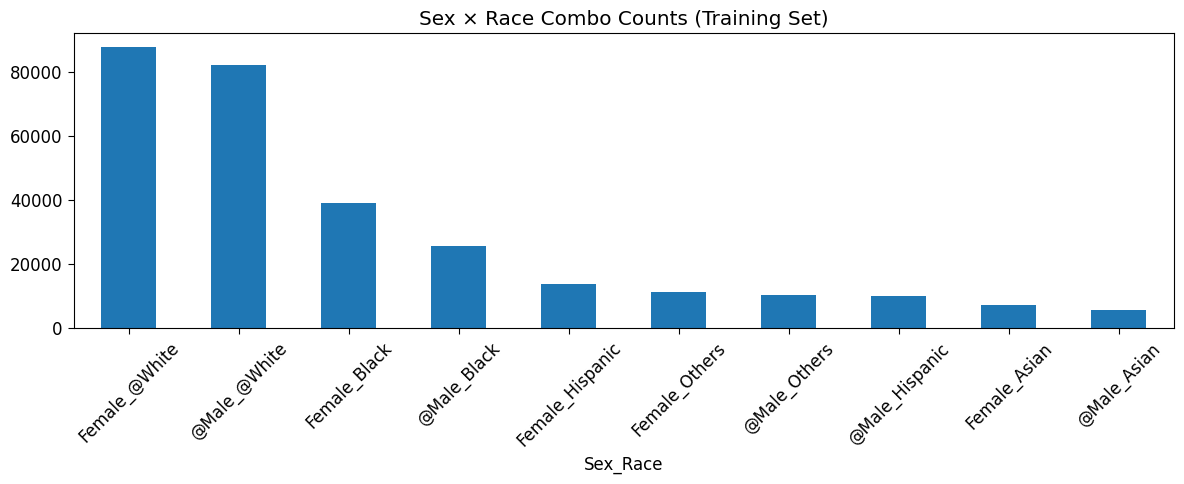

<Figure size 1000x600 with 0 Axes>

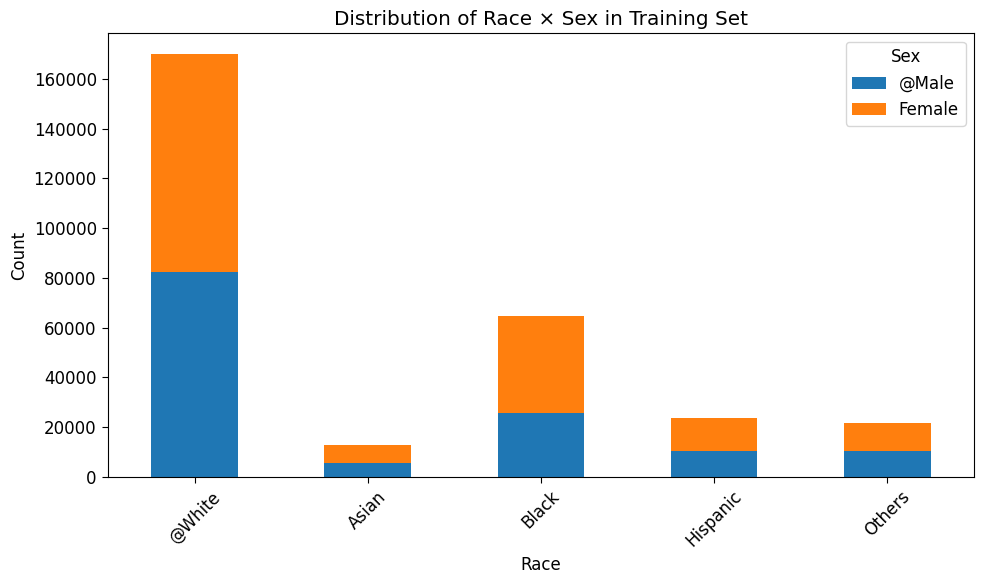

In [ ]:
datasets = {
    "Training Set": dat_train,
    #"Validation Set": dat_expl,
    #"Test Set": dat_test
}

for name, i in datasets.items():
    dist_counts = pd.crosstab(i['Sex'], i['Race'])
    dist_percent = dist_counts.div(dist_counts.sum(axis=1), axis=0) * 100

    i['Sex_Race'] = i['Sex'] + "_" + i['Race']
    combo_counts = i['Sex_Race'].value_counts()
    print(f"\nCounts of Sex_Race combinations in {name}:")
    display(combo_counts)

    # Bar chart
    combo_counts.plot(kind='bar', figsize=(12,5), title=f"Sex × Race Combo Counts ({name})", )
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Stacked bar chart
    plt.figure(figsize=(10,6))
    dist_counts.T.plot(kind='bar', stacked=True, figsize=(10,6))
    plt.title(f"Distribution of Sex × Race in {name}")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


Outcome (Hospitalization) Distribution:
label
0    154100
1    138517
Name: count, dtype: int64


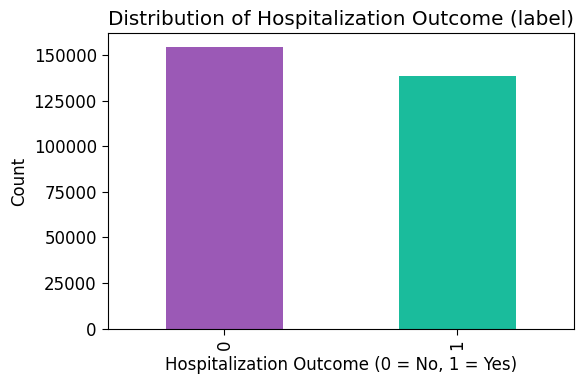

In [ ]:
# Count distribution
label_counts = dat_train['label'].value_counts()
print("Outcome (Hospitalization) Distribution:")
print(label_counts)

# Bar plot
plt.figure(figsize=(6,4))
label_counts.plot(kind='bar', color=['#9b59b6', '#1abc9c'])
plt.title("Distribution of Hospitalization Outcome (label)")
plt.xlabel("Hospitalization Outcome (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

Pretty much balanced.


=== SEX ===


label,0,1
Sex,,
@Male,49.009731,50.990269
Female,55.740327,44.259673


<Figure size 700x500 with 0 Axes>

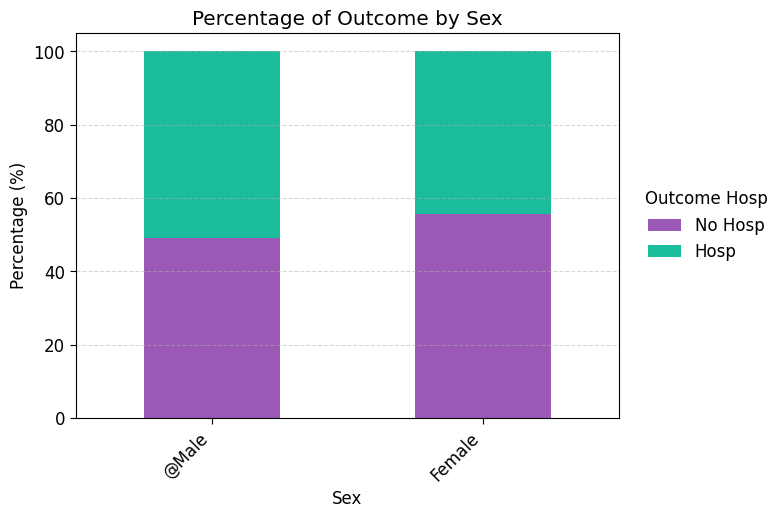


=== RACE ===


label,0,1
Race,,
@White,46.653525,53.346475
Asian,61.334481,38.665519
Black,60.766934,39.233066
Hispanic,64.908440,35.091560
Others,57.107626,42.892374


<Figure size 700x500 with 0 Axes>

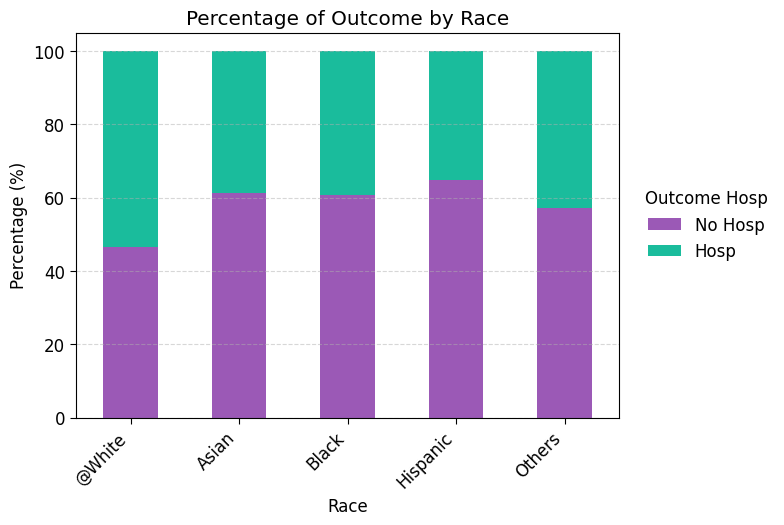

In [ ]:
protected_attrs = ["Sex", "Race"]

for attr in protected_attrs:
    print(f"\n=== {attr.upper()} ===")

    # Crosstab: counts
    ct = pd.crosstab(dat_train[attr], dat_train['label'])

    # Convert to row percentages
    pct = ct.div(ct.sum(axis=1), axis=0) * 100

    # Print table
    display(pct)

    # Plot
    plt.figure(figsize=(7,5))
    pct.plot(kind='bar', stacked=True, figsize=(7,5), color=['#9b59b6', '#1abc9c'])

    plt.title(f"Percentage of Outcome by {attr}")
    plt.ylabel("Percentage (%)")
    plt.legend(["No Hosp", "Hosp"], title="Outcome Hosp", loc="center left", bbox_to_anchor=(1.02, 0.5), frameon=False)
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.xticks(rotation=45, ha="right")

    plt.show()


label,0,1
Sex_Race,,
@Male | @White,44.206353,55.793647
@Male | Asian,58.566372,41.433628
@Male | Black,56.290977,43.709023
@Male | Hispanic,59.598457,40.401543
@Male | Others,53.655903,46.344097
Female | @White,48.947692,51.052308
Female | Asian,63.526773,36.473227
Female | Black,63.706020,36.293980
Female | Hispanic,68.843448,31.156552


<Figure size 1200x600 with 0 Axes>

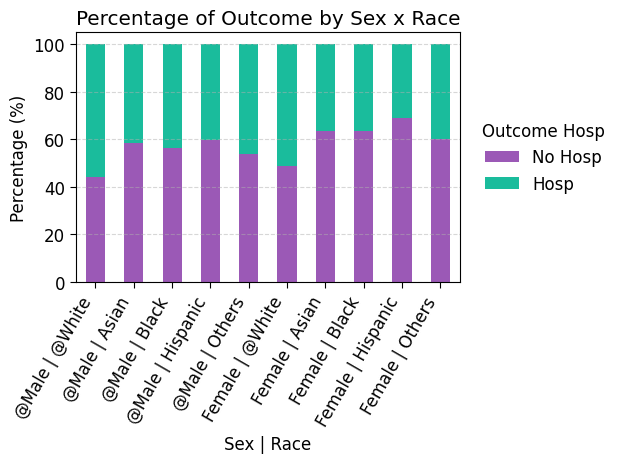

In [ ]:
# Create combined column
dat_train["Sex_Race"] = dat_train["Sex"].astype(str) + " | " + dat_train["Race"].astype(str)

# Crosstab: counts
ct = pd.crosstab(dat_train["Sex_Race"], dat_train["label"])

# Convert to row percentages
pct = ct.div(ct.sum(axis=1), axis=0) * 100

# Display
display(pct.sort_index())

# Plot
plt.figure(figsize=(12,6))
pct.plot(kind='bar', stacked=True,  color=['#9b59b6', '#1abc9c'])

plt.title("Percentage of Outcome by Sex x Race")
plt.ylabel("Percentage (%)")
plt.xlabel("Sex | Race")
plt.legend(["No Hosp", "Hosp"], title="Outcome Hosp", loc="center left", bbox_to_anchor=(1.02, 0.5), frameon=False)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.xticks(rotation=60, ha="right")
plt.tight_layout()
plt.show()
